## Load libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pathlib
import matplotlib.pyplot as plt
# import heapq, random
import pandas as pd

In [ ]:
!pip install -q rasterio
import rasterio

     |████████████████████████████████| 19.3 MB 6.2 MB/s 


In [ ]:
import tensorflow as tf

In [ ]:
import random


## Open and scale

In [65]:
#same for y
def open_tiff(x):
  raster = rasterio.open(x)
  x = raster.read()
  # shape needs to be (256,256,1) (currently 1,256,256) Might depend per region what they have..
  x_moved = np.moveaxis(x, 0, -1) #np array, source  (axis), destination (axis)
  return x_moved

In [66]:
#same for y
def open_tiff_amp_slope(x):
  raster = rasterio.open(x)
  sar1 = raster.read(2)
  sar2 = raster.read(1)
  dem = raster.read(3)
  # shape needs to be (256,256,1) (currently 1,256,256) Might depend per region what they have..
  # x_moved = np.moveaxis(x, 0, -1) #np array, source  (axis), destination (axis)
  # return x_moved
  return sar1,sar2,dem

In [67]:
def inverse_scaleGrid(input_grid,leftMin,leftMax, rightMin,rightMax): 
  '''
  objective: bring the scaled data into the original range
  input_grid: grid with values
  leftMin,leftMax: min and max of the original input grid
  rightMin,rightMax: min and max of the range to which the data was mapped  
  '''
  leftSpan = leftMax - leftMin
  rightSpan=rightMax-rightMin
 
  valueInversedScaled = (input_grid - rightMin)/rightSpan
  valueInversedScaled = valueInversedScaled * leftSpan + leftMin
 
  return valueInversedScaled

In [68]:
#function to map from left (original) to right (scaled)
def scaleGrid(input_grid,leftMin,leftMax, rightMin,rightMax):
  '''
  objective: map the values of the input grid to the proposed range
  input_grid: grid with values
  leftMin,leftMax: min and max of the original input grid
  rightMin,rightMax: min and max of the range to which the data is mapped  
  '''
 
  leftSpan = leftMax - leftMin
  rightSpan= rightMax - rightMin
 
  valueScaled = (input_grid - leftMin) / float(leftSpan)
  valueScaled = np.round(rightMin + (valueScaled * rightSpan),4)

 
  return valueScaled

In [69]:
def remove_bad_pixels_before_scaling(sar1,sar2,dem):
  
  bad_pixel = -29.0
  fill = -29.0

  #Remove values below -30 dB as suggested by GEE. Would have been nicer if done during export but whateve
  id1 = np.argwhere(sar1 <= bad_pixel)
  for i in range(len(id1)):
    (sar1[id1[i][0],id1[i][1]]) = fill
  
  id2 = np.argwhere(sar2 <= bad_pixel)
  for i in range(len(id2)):
    (sar2[id2[i][0],id2[i][1]]) = fill

  id3 = np.argwhere(dem <= 0.0)
  for i in range(len(id3)):
    (dem[id3[i][0],id3[i][1]]) = 0.0

  #also do removeNan here
  sar1 = remove_nan(sar1,fill)
  sar2 = remove_nan(sar2,fill)
  dem = remove_nan(dem,fill)

  return sar1,sar2,dem

In [70]:
def remove_nan(arr,fill):
  arr[np.isnan(arr)] = fill
  return arr

In [71]:
def scale_x_A_ratio(sar,min_sar,max_sar,max_value = 0.8):

  #scale X
  # sar = scaleGrid(sar,min_sar,max_sar,-1,max_value)
  # sar = remove_nan(sar,fill = -1)
  sar = scaleGrid(sar,min_sar,max_sar,0,1)
  sar = remove_nan(sar,fill = 0)
  return sar

In [72]:
def scale_x(sar1,sar2,dem,max_sar,max_value = 0.8):

  #scale X
  min_sar = -29 
  # max_sar = 26 #differs per asc/des.
  min_dem = 0
  max_dem = 85

  #remove - 30 dB

  # sar1 = scaleGrid(sar1,min_sar,max_sar,-1,max_value)
  # sar2 = scaleGrid(sar2,min_sar,max_sar,-1,max_value)
  # dem = scaleGrid(dem,min_dem,max_dem,-1,max_value)
  sar1 = scaleGrid(sar1,min_sar,max_sar,0,1)
  sar2 = scaleGrid(sar2,min_sar,max_sar,0,1)
  dem = scaleGrid(dem,min_dem,max_dem,0,1)

  return sar1,sar2,dem

In [73]:
def scale_dem(dem,max_value = 0.8):
  
  #remove <0 dem values, change to 0 values
  #how...
  dem[dem<0] = 0


  #scale dem
  min_dem = 0
  max_dem = 85 
  # dem = scaleGrid(dem,min_dem,max_dem,-1,max_value)
  # dem = remove_nan(dem,fill = -1)

  dem = scaleGrid(dem,min_dem,max_dem,0,1)
  dem = remove_nan(dem,fill = 0)
  return dem

In [74]:
def scale_y(y):
  fill = -1
  # scaled_y = scaleGrid(y,0,255,-1,1)
  # scaled_y = remove_nan(scaled_y,fill)

  scaled_y = scaleGrid(y,0,255,0,1)
  scaled_y = remove_nan(scaled_y,0)

  return scaled_y


In [75]:
def to_np_float(arr):
  arr = np.float32(arr)
  return arr

## Check/ plot images 0 1

In [105]:
def check_images_A_ratio(x,y,min_sar,max_sar,fn,name):
  x = open_tiff(x)
  y = open_tiff(y)

  #scale
  x_sc = scale_x_A_ratio(x,min_sar,max_sar)
  y_sc = scale_y(y)

  # print(x_sc[:,:,0].shape,y_sc[:,:,0].shape,x[:,:,0].shape,y[:,:,0].shape)

  titles = ["source"," target","scaled source","scaled target"]
  images = [x[:,:,0],y[:,:,0]]
  images_sc = [x_sc[:,:,0],y_sc[:,:,0]]

    #print the values
  print('source ratio',images[0])
  print('source target',images[1])
  print('scaled ratio',images_sc[0])
  print('scaled target',images_sc[1])

  plt.figure(figsize=(6, 3))
  plt.subplot(121)
  plt.imshow(images_sc[0])
  plt.title(titles[0])
  plt.subplot(122)
  plt.imshow(images_sc[1])
  plt.title(titles[1])

  plt.savefig(fn + name +'_plot_a_ratio_v2.png',dpi=300,bbox_inches = 'tight')
  plt.show()
  plt.close()


In [120]:
def check_images_amp_slope(x,y,max_sar,fn,name):

  #open x and y
  sar1,sar2,dem = open_tiff_amp_slope(x)
  sar1,sar2,dem = remove_bad_pixels_before_scaling(sar1,sar2,dem) #do -30 first???!
  y = open_tiff(y)

  # image_x = np.stack((sar1[:,:,0],sar2[:,:,0],dem[:,:,0]),axis = -1)
  image_x = np.stack((sar1,sar2,dem),axis = -1)


  # #scale
  sar1_sc,sar2_sc,dem_sc = scale_x(sar1,sar2,dem,max_sar)
  image_x_sc = np.stack((sar1_sc,sar2_sc,dem_sc),axis = -1)
  y_sc = scale_y(y)

  # #plot both unscaled and scaled to compare. Also compare the non scaled to the one in qgis (the og tiff)
  # #because imshow itself also scale
  titles = ["sar1","sar2", "slope", "source", "target","scaled \n sar1","scaled \n sar2","scaled \n dem","scaled \n source","scaled \n target" ]
  images = [sar1,sar2,dem,image_x,y[:,:,0]]
  images_sc = [sar1_sc,sar2_sc,dem_sc,image_x_sc,y_sc[:,:,0]]

  print('source sar 1 im',images[0])
  print('source sar 2 im',images[1])
  print('source dem im',images[2])
  print('source 3 band im',images[3])
  print('target im',images[4])

  print('scaled sar 1 im',images_sc[0])
  print('scaled sar 2 im',images_sc[1])
  print('scaled dem im',images_sc[2])
  print('scaled 3 band im',images_sc[3])
  print('scaled target im',images_sc[4])

  plt.figure(figsize=(12, 3))

  plt.subplot(141)
  plt.imshow(images_sc[0])
  plt.title(titles[0])
  plt.subplot(142)
  plt.imshow(images_sc[1])
  plt.title(titles[1])
  plt.subplot(143)
  plt.imshow(images_sc[2])
  plt.title(titles[2])
  plt.subplot(144)
  plt.imshow(images_sc[3])
  plt.title(titles[3])




 

  plt.savefig(fn + name +'_plot_src_v2.png',dpi=300,bbox_inches = 'tight')
  plt.show()
  plt.close()
  




In [119]:
def check_images_A_ratio_dem(x,y,dem,min_sar,max_sar,fn,name):
  
  x = open_tiff(x)
  dem = open_tiff(dem)
  y = open_tiff(y)

  
  #scale
  x_sc = scale_x_A_ratio(x,min_sar,max_sar)
  dem_sc = scale_dem(dem)
  y_sc = scale_y(y)

  # image_x = np.stack((x[:,:,0],dem[:,:,0],dem[:,:,0]),axis = -1) #cannot plot images with just 2 bands..
  # image_x_sc = np.stack((x_sc[:,:,0],dem_sc[:,:,0],dem_sc[:,:,0]),axis = -1)
  # dummy = np.zeros((256,256))
  # image_x = np.stack((x[:,:,0],dem[:,:,0],dummy),axis = -1) #cannot plot images with just 2 bands..
  # image_x_sc = np.stack((x_sc[:,:,0],dem_sc[:,:,0],dummy),axis = -1)

  image_x = np.stack((x[:,:,0],x[:,:,0],dem[:,:,0]),axis = -1) #cannot plot images with just 2 bands..
  image_x_sc = np.stack((x_sc[:,:,0],x_sc[:,:,0],dem_sc[:,:,0]),axis = -1)


  titles = ["A ratio","slope","source", "target","A ratio scaled","dem scaled","source scaled", "target scaled"]
  images = [x[:,:,0],dem[:,:,0],image_x,y[:,:,0]]
  images_sc = [x_sc[:,:,0],dem_sc[:,:,0],image_x_sc,y_sc[:,:,0]]

  print('source ratio im',images[0])
  print('source dem im',images[1])
  print('source 3 band im',images[2])
  print('target im',images[3])

  print('scaled ratio im',images_sc[0])
  print('scaled dem im',images_sc[1])
  print('scaled 3 band im',images_sc[2])
  print('scaled target im',images_sc[3])


  plt.figure(figsize=(9, 3))

  plt.subplot(131)
  plt.imshow(images_sc[0])
  plt.title(titles[0])
  plt.subplot(132)
  plt.imshow(images_sc[1])
  plt.title(titles[1])
  plt.subplot(133)
  plt.imshow(images_sc[2])
  plt.title(titles[2])
 

  plt.savefig(fn + name +'_plot_a_ratio_dem_v2.png',dpi=300,bbox_inches = 'tight')
  plt.show()
  plt.close()


# Run

##get path files

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = "/content/drive/MyDrive/Thesis/src_tar_check/"
!ls -la {path}

total 20
drwx------ 2 root root 4096 Oct  4 12:52 ampslope
drwx------ 2 root root 4096 Oct  4 12:52 a_ratio
drwx------ 2 root root 4096 Oct  4 12:52 a_ratio_dem
drwx------ 2 root root 4096 Oct  5 09:37 dem
drwx------ 2 root root 4096 Oct  4 12:52 y


In [ ]:
!ls -la {path + "ampslope"}

total 2972
-rw------- 1 root root 710466 Oct  5 12:21 ampslope_112_plot_src.png
-rw------- 1 root root 687997 Oct  5 12:21 ampslope_113_plot_src.png
-rw------- 1 root root 704820 Oct  5 12:21 ampslope_114_plot_src.png
-rw------- 1 root root 153333 Oct  4 12:52 ImagePost0_4.tif
-rw------- 1 root root 153569 Oct  4 12:52 ImagePre3_4.tif
-rw------- 1 root root 197547 Oct  4 12:52 ImageXLS_112.tif
-rw------- 1 root root 213545 Oct  4 12:52 ImageXLS_113.tif
-rw------- 1 root root 220163 Oct  4 12:52 ImageXLS_114.tif


In [ ]:
y_path = path + "y/"
x_path_ampslope = path + "ampslope/"
x_path_ratio = path + "a_ratio/"
x_path_ratio_dem = path + "a_ratio_dem/"
x_path_dem = path + "dem/"

In [ ]:
def get_files_string(path):
  files = [str(f) for f in pathlib.Path(path).glob('*.tif')]
  return files

In [ ]:
files_y = get_files_string(y_path)
files_y

['/content/drive/MyDrive/Thesis/src_tar_check/y/ImageNonLS.tif',
 '/content/drive/MyDrive/Thesis/src_tar_check/y/ImageLS_112.tif',
 '/content/drive/MyDrive/Thesis/src_tar_check/y/ImageLS_113.tif',
 '/content/drive/MyDrive/Thesis/src_tar_check/y/ImageLS_114.tif']

In [ ]:
ampslope = get_files_string(x_path_ampslope)
ampslope

['/content/drive/MyDrive/Thesis/src_tar_check/ampslope/ImagePost0_4.tif',
 '/content/drive/MyDrive/Thesis/src_tar_check/ampslope/ImageXLS_112.tif',
 '/content/drive/MyDrive/Thesis/src_tar_check/ampslope/ImageXLS_114.tif',
 '/content/drive/MyDrive/Thesis/src_tar_check/ampslope/ImageXLS_113.tif',
 '/content/drive/MyDrive/Thesis/src_tar_check/ampslope/ImagePre3_4.tif']

In [ ]:
ratio = get_files_string(x_path_ratio)
ratio

['/content/drive/MyDrive/Thesis/src_tar_check/a_ratio/ImageXLS_113.tif',
 '/content/drive/MyDrive/Thesis/src_tar_check/a_ratio/ImageXLS_114.tif',
 '/content/drive/MyDrive/Thesis/src_tar_check/a_ratio/ImageXLS_112.tif']

In [ ]:
ratio_dem = get_files_string(x_path_ratio_dem)
ratio_dem

['/content/drive/MyDrive/Thesis/src_tar_check/a_ratio_dem/ImageXLS_113.tif',
 '/content/drive/MyDrive/Thesis/src_tar_check/a_ratio_dem/ImageXLS_112.tif',
 '/content/drive/MyDrive/Thesis/src_tar_check/a_ratio_dem/ImageXLS_114.tif']

In [ ]:
dem = get_files_string(x_path_dem)
dem

['/content/drive/MyDrive/Thesis/src_tar_check/dem/ImageDEM_112.tif',
 '/content/drive/MyDrive/Thesis/src_tar_check/dem/ImageDEM_114.tif',
 '/content/drive/MyDrive/Thesis/src_tar_check/dem/ImageDEM_113.tif']

## run

source ratio [[-0.32036666 -0.15734534  0.00313658 ...  0.91775525  0.99545237
   0.93538083]
 [-0.27911746 -0.14941397 -0.03380912 ...  0.7013149   0.86808936
   0.93131347]
 [-0.12998062 -0.02360509  0.0493088  ...  0.42366989  0.64997663
   0.80304728]
 ...
 [ 0.10274385  0.05135351  0.08437017 ... -0.65801719 -0.47359376
  -0.4756381 ]
 [ 0.27185285  0.17000886  0.15240559 ... -0.79851606 -0.59609822
  -0.59574933]
 [ 0.35261791  0.23878901  0.19444784 ... -0.88756306 -0.71357719
  -0.71968882]]
source target [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
scaled ratio [[0.5466 0.5523 0.5578 ... 0.5895 0.5922 0.5901]
 [0.5481 0.5526 0.5565 ... 0.582  0.5878 0.5899]
 [0.5532 0.5569 0.5594 ... 0.5724 0.5802 0.5855]
 ...
 [0.5613 0.5595 0.5606 ... 0.535  0.5413 0.5413]
 [0.5671 0.5636 0.563  ... 0.5301 0.5371 0.5371]
 [0.5699 0.566  0.5644 ... 0.527  0.533  0.5328]]
scaled target [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0

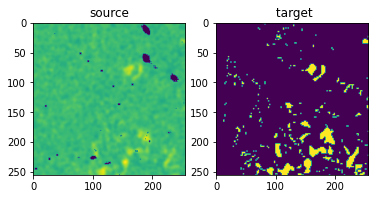

/content/drive/MyDrive/Thesis/src_tar_check/a_ratio/ImageXLS_113.tif /content/drive/MyDrive/Thesis/src_tar_check/y/ImageLS_113.tif
source ratio [[ 0.85825898  0.8807314   0.99846639 ...  0.29000626  0.18681548
  -0.00182034]
 [ 0.97870133  1.10249298  1.28372818 ...  0.42934047  0.34977916
   0.17957424]
 [ 0.93422274  1.11278599  1.31867944 ...  0.46811875  0.44238269
   0.34741588]
 ...
 [-0.67197276 -0.95392958 -1.183589   ...         nan -0.18743563
          nan]
 [-0.78905257 -1.05634679 -1.25476061 ... -0.50682738 -0.33389045
  -0.1606824 ]
 [-0.8831836  -1.09019082 -1.21836253 ... -0.67907677 -0.53450996
  -0.34178209]]
source target [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
scaled ratio [[0.5874 0.5882 0.5923 ... 0.5678 0.5642 0.5577]
 [0.5916 0.5959 0.6021 ... 0.5726 0.5698 0.5639]
 [0.59   0.5962 0.6033 ... 0.5739 0.573  0.5697]
 ...
 [0.5345 0.5247 0.5168 ... 0.     0.5512 0.    ]
 [0.5304 0.5212 

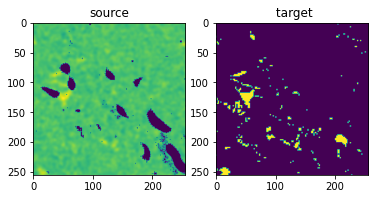

/content/drive/MyDrive/Thesis/src_tar_check/a_ratio/ImageXLS_114.tif /content/drive/MyDrive/Thesis/src_tar_check/y/ImageLS_114.tif
source ratio [[-0.16534283 -0.18147563 -0.00668196 ...  0.03797626  0.03989034
   0.01219073]
 [ 0.0207594  -0.0206336   0.0961399  ... -0.26557362 -0.23852143
  -0.24336898]
 [ 0.26211372  0.25782147  0.35583387 ... -0.4170134  -0.36716986
  -0.36098732]
 ...
 [        nan         nan         nan ... -0.98719794 -1.40700795
  -1.68416695]
 [-0.09419768 -0.16117865 -0.30746193 ... -1.16769803 -1.68816776
          nan]
 [-0.21473171 -0.19793608 -0.25726889 ... -1.24270497 -1.82959199
  -2.22669958]]
source target [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
scaled ratio [[0.552  0.5514 0.5575 ... 0.559  0.5591 0.5581]
 [0.5584 0.557  0.561  ... 0.5485 0.5495 0.5493]
 [0.5668 0.5666 0.57   ... 0.5433 0.545  0.5452]
 ...
 [0.     0.     0.     ... 0.5236 0.509  0.4995]
 [0.5545 0.5521 

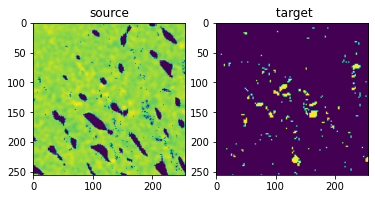

In [106]:
#min max sar for a ratio
min_sar = -16.120684610798055
max_sar = 12.783960937574514
fn = x_path_ratio
check_images_A_ratio(ratio[-1],files_y[1],min_sar,max_sar,fn,'a_ratio_112')

print(ratio[0],files_y[2])
check_images_A_ratio(ratio[0],files_y[2],min_sar,max_sar,fn,'a_ratio_113')


print(ratio[1],files_y[3])
check_images_A_ratio(ratio[1],files_y[3],min_sar,max_sar,fn,'a_ratio_114')

/content/drive/MyDrive/Thesis/src_tar_check/ampslope/ImageXLS_113.tif /content/drive/MyDrive/Thesis/src_tar_check/y/ImageLS_113.tif
source sar 1 im [[-14 -11 -12 ... -13 -14 -13]
 [-16 -14 -13 ... -14 -15 -14]
 [-21 -18 -18 ... -16 -17 -18]
 ...
 [-11 -10 -11 ... -15 -15 -13]
 [ -8  -7  -8 ... -15 -16 -15]
 [ -7  -7  -7 ... -13 -15 -14]]
source sar 2 im [[-12 -12 -13 ... -14 -14 -13]
 [-14 -15 -17 ... -14 -14 -14]
 [-18 -18 -18 ... -12 -13 -14]
 ...
 [-10  -7  -6 ... -17 -16 -16]
 [ -8  -6  -6 ... -15 -15 -16]
 [ -8  -6  -6 ... -11 -13 -17]]
source dem im [[12 12 12 ...  6  6  8]
 [12 12 12 ...  6  6  8]
 [ 9  9  9 ... 15 15 17]
 ...
 [29 29 29 ... 39 39 28]
 [29 29 29 ... 39 39 28]
 [29 29 29 ... 39 39 28]]
source 3 band im [[[-14 -12  12]
  [-11 -12  12]
  [-12 -13  12]
  ...
  [-13 -14   6]
  [-14 -14   6]
  [-13 -13   8]]

 [[-16 -14  12]
  [-14 -15  12]
  [-13 -17  12]
  ...
  [-14 -14   6]
  [-15 -14   6]
  [-14 -14   8]]

 [[-21 -18   9]
  [-18 -18   9]
  [-18 -18   9]
  ...
  [

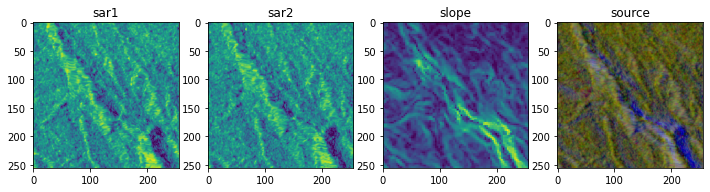

/content/drive/MyDrive/Thesis/src_tar_check/ampslope/ImageXLS_114.tif /content/drive/MyDrive/Thesis/src_tar_check/y/ImageLS_114.tif
source sar 1 im [[-13 -15 -19 ... -18 -23 -24]
 [-14 -17 -18 ... -19 -21 -26]
 [-18 -18 -15 ... -19 -20 -23]
 ...
 [-13 -13 -15 ... -27 -23 -23]
 [-15 -13 -14 ... -24 -25 -25]
 [-14 -14 -16 ... -22 -26 -21]]
source sar 2 im [[-13 -13 -17 ... -19 -23 -20]
 [-14 -15 -17 ... -21 -21 -24]
 [-14 -16 -15 ... -19 -19 -21]
 ...
 [-16 -18 -18 ... -22 -19 -29]
 [-16 -17 -18 ... -21 -23 -26]
 [-17 -17 -15 ... -19 -25 -29]]
source dem im [[ 8  8  8 ... 24 24 31]
 [ 8  8  8 ... 24 24 31]
 [17 17 17 ... 22 22 33]
 ...
 [28 28 28 ... 44 44 45]
 [28 28 28 ... 44 44 45]
 [28 28 28 ... 44 44 45]]
source 3 band im [[[-13 -13   8]
  [-15 -13   8]
  [-19 -17   8]
  ...
  [-18 -19  24]
  [-23 -23  24]
  [-24 -20  31]]

 [[-14 -14   8]
  [-17 -15   8]
  [-18 -17   8]
  ...
  [-19 -21  24]
  [-21 -21  24]
  [-26 -24  31]]

 [[-18 -14  17]
  [-18 -16  17]
  [-15 -15  17]
  ...
  [

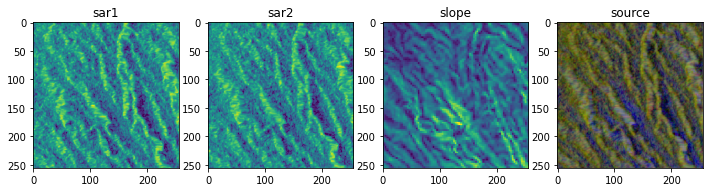

/content/drive/MyDrive/Thesis/src_tar_check/ampslope/ImageXLS_112.tif /content/drive/MyDrive/Thesis/src_tar_check/y/ImageLS_112.tif
source sar 1 im [[-18 -18 -17 ... -14 -14 -16]
 [-19 -18 -18 ... -15 -17 -21]
 [-18 -17 -18 ... -18 -18 -20]
 ...
 [-17 -17 -16 ... -12 -10  -8]
 [-18 -15 -13 ... -10  -9  -7]
 [-14 -12 -13 ... -12 -11  -9]]
source sar 2 im [[-16 -15 -14 ... -22 -16 -14]
 [-14 -17 -16 ... -19 -19 -18]
 [-14 -17 -16 ... -19 -19 -18]
 ...
 [-13 -13 -12 ... -12 -12  -8]
 [-13 -13 -12 ... -12 -12  -8]
 [-16 -16 -14 ... -14 -11  -8]]
source dem im [[10 10 10 ... 15 15 12]
 [10 10 10 ... 15 15 12]
 [ 8  8  8 ... 12 12  9]
 ...
 [ 3  3  3 ... 30 30 30]
 [ 3  3  3 ... 30 30 30]
 [ 3  3  3 ... 30 30 30]]
source 3 band im [[[-18 -16  10]
  [-18 -15  10]
  [-17 -14  10]
  ...
  [-14 -22  15]
  [-14 -16  15]
  [-16 -14  12]]

 [[-19 -14  10]
  [-18 -17  10]
  [-18 -16  10]
  ...
  [-15 -19  15]
  [-17 -19  15]
  [-21 -18  12]]

 [[-18 -14   8]
  [-17 -17   8]
  [-18 -16   8]
  ...
  [

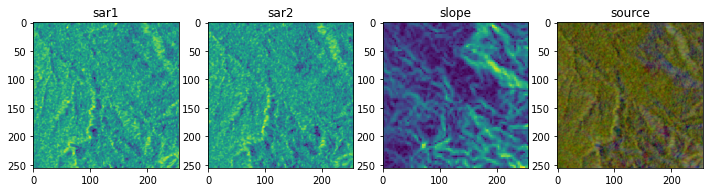

In [121]:
fn = x_path_ampslope
print(ampslope[3],files_y[2])
check_images_amp_slope(ampslope[3],files_y[2],max_sar,fn,'ampslope_113')
print(ampslope[2],files_y[3])
check_images_amp_slope(ampslope[2],files_y[3],max_sar,fn,'ampslope_114')
print(ampslope[1],files_y[1])
check_images_amp_slope(ampslope[1],files_y[1],max_sar,fn,'ampslope_112')

In [122]:


#for a ratio dem
min_sar = -16.79680289037293
max_sar = 12.783960937574514

/content/drive/MyDrive/Thesis/src_tar_check/a_ratio_dem/ImageXLS_112.tif /content/drive/MyDrive/Thesis/src_tar_check/y/ImageLS_112.tif /content/drive/MyDrive/Thesis/src_tar_check/dem/ImageDEM_112.tif
source ratio im [[-0.32036666 -0.15734534  0.00313658 ...  0.91775525  0.99545237
   0.93538083]
 [-0.27911746 -0.14941397 -0.03380912 ...  0.7013149   0.86808936
   0.93131347]
 [-0.12998062 -0.02360509  0.0493088  ...  0.42366989  0.64997663
   0.80304728]
 ...
 [ 0.10274385  0.05135351  0.08437017 ... -0.65801719 -0.47359376
  -0.4756381 ]
 [ 0.27185285  0.17000886  0.15240559 ... -0.79851606 -0.59609822
  -0.59574933]
 [ 0.35261791  0.23878901  0.19444784 ... -0.88756306 -0.71357719
  -0.71968882]]
source dem im [[10.559128  10.559128  10.559128  ... 15.126151  15.126151  15.126151 ]
 [10.559128  10.559128  10.559128  ... 15.126151  15.126151  15.126151 ]
 [ 8.3764925  8.3764925  8.3764925 ... 12.006311  12.006311  12.006311 ]
 ...
 [ 3.7445035  3.7445035  3.7445035 ... 30.029305  30.0

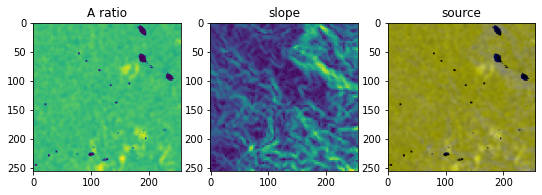

/content/drive/MyDrive/Thesis/src_tar_check/a_ratio_dem/ImageXLS_113.tif /content/drive/MyDrive/Thesis/src_tar_check/y/ImageLS_113.tif /content/drive/MyDrive/Thesis/src_tar_check/dem/ImageDEM_113.tif
source ratio im [[ 0.85825898  0.8807314   0.99846639 ...  0.29000626  0.18681548
  -0.00182034]
 [ 0.97870133  1.10249298  1.28372818 ...  0.42934047  0.34977916
   0.17957424]
 [ 0.93422274  1.11278599  1.31867944 ...  0.46811875  0.44238269
   0.34741588]
 ...
 [-0.67197276 -0.95392958 -1.183589   ...         nan -0.18743563
          nan]
 [-0.78905257 -1.05634679 -1.25476061 ... -0.50682738 -0.33389045
  -0.1606824 ]
 [-0.8831836  -1.09019082 -1.21836253 ... -0.67907677 -0.53450996
  -0.34178209]]
source dem im [[12.961303 12.961303 12.961303 ...  6.210721  6.210721  8.255931]
 [12.961303 12.961303 12.961303 ...  6.210721  6.210721  8.255931]
 [ 9.257111  9.257111  9.257111 ... 15.123666 15.123666 17.091166]
 ...
 [29.381538 29.381538 29.381538 ... 39.647243 39.647243 28.440691]
 [29.

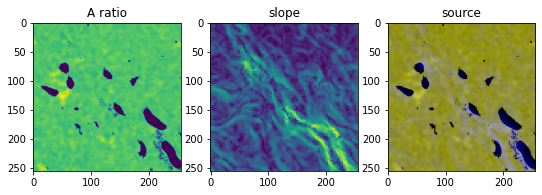

/content/drive/MyDrive/Thesis/src_tar_check/a_ratio_dem/ImageXLS_114.tif /content/drive/MyDrive/Thesis/src_tar_check/y/ImageLS_114.tif /content/drive/MyDrive/Thesis/src_tar_check/dem/ImageDEM_114.tif
source ratio im [[-0.16534283 -0.18147563 -0.00668196 ...  0.03797626  0.03989034
   0.01219073]
 [ 0.0207594  -0.0206336   0.0961399  ... -0.26557362 -0.23852143
  -0.24336898]
 [ 0.26211372  0.25782147  0.35583387 ... -0.4170134  -0.36716986
  -0.36098732]
 ...
 [        nan         nan         nan ... -0.98719794 -1.40700795
  -1.68416695]
 [-0.09419768 -0.16117865 -0.30746193 ... -1.16769803 -1.68816776
          nan]
 [-0.21473171 -0.19793608 -0.25726889 ... -1.24270497 -1.82959199
  -2.22669958]]
source dem im [[ 8.255931  8.255931  8.255931 ... 24.70162  24.70162  31.907923]
 [ 8.255931  8.255931  8.255931 ... 24.70162  24.70162  31.907923]
 [17.091166 17.091166 17.091166 ... 22.633375 22.633375 33.078373]
 ...
 [28.440691 28.440691 28.440691 ... 44.7453   44.7453   45.584873]
 [28.

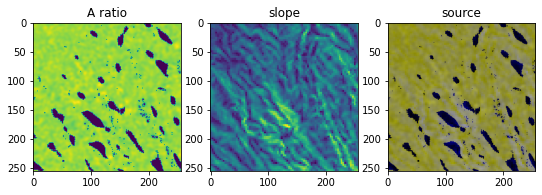

In [123]:
fn = x_path_ratio_dem
print(ratio_dem[1],files_y[1],dem[0])
check_images_A_ratio_dem(ratio_dem[1],files_y[1],dem[0],min_sar,max_sar,fn,'a_ratio_dem_v2_112')
print(ratio_dem[0],files_y[2],dem[2])
check_images_A_ratio_dem(ratio_dem[0],files_y[2],dem[2],min_sar,max_sar,fn,'a_ratio_dem_v2_113')
print(ratio_dem[2],files_y[3],dem[1])
check_images_A_ratio_dem(ratio_dem[2],files_y[3],dem[1],min_sar,max_sar,fn,'a_ratio_dem_114')